### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [1]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 20    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

--2024-06-03 08:50:41--  https://huggingface.co/FoundationVision/var/resolve/main/var_d20.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.55, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/27/33/2733ebd65833f8330005ce942c9195c84a3d385ac604d32ebe5d6d9a79385456/f7d232978e6fe82a4f2e0f5d82b012e01b1aa5abfe93ce2b56104ec0e878a10f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27var_d20.pth%3B+filename%3D%22var_d20.pth%22%3B&Expires=1717663842&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzY2Mzg0Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzI3LzMzLzI3MzNlYmQ2NTgzM2Y4MzMwMDA1Y2U5NDJjOTE5NWM4NGEzZDM4NWFjNjA0ZDMyZWJlNWQ2ZDlhNzkzODU0NTYvZjdkMjMyOTc4ZTZmZTgyYTRmMmUwZjVkODJiMDEyZTAxYjFhYTVhYmZlOTNjZTJiNTYxMDRlYzBlODc4YTEwZj9yZXN


[constructor]  ==== flash_if_available=True (0/20), fused_if_available=True (fusing_add_ln=0/20, fusing_mlp=0/20) ==== 
    [VAR config ] embed_dim=1280, num_heads=20, depth=20, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0833333 (tensor([0.0000, 0.0044, 0.0088, 0.0132, 0.0175, 0.0219, 0.0263, 0.0307, 0.0351,
        0.0395, 0.0439, 0.0482, 0.0526, 0.0570, 0.0614, 0.0658, 0.0702, 0.0746,
        0.0789, 0.0833]))

[init_weights] VAR with init_std=0.0161374
prepare finished.


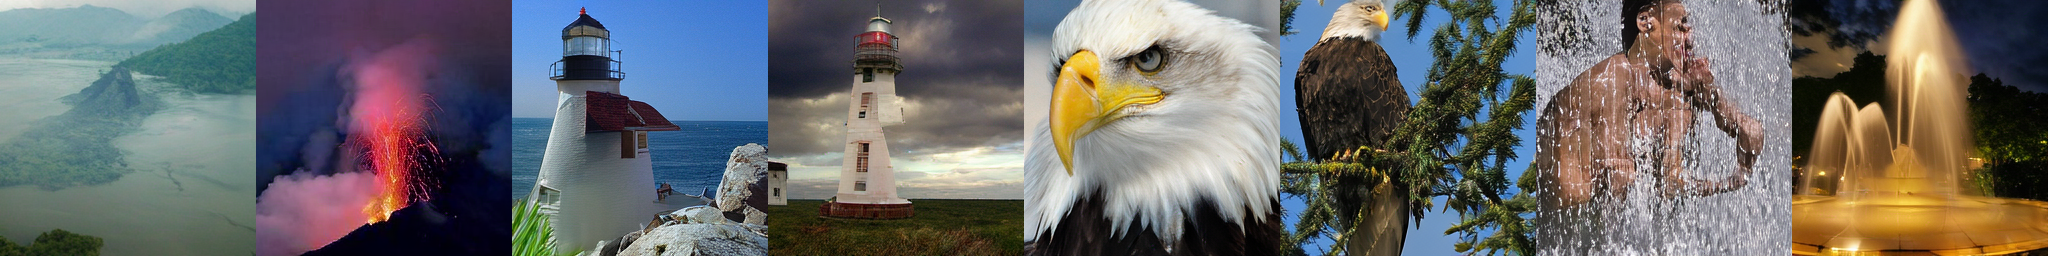

In [2]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw.show()


In [1]:
import torch
from utils.data import build_dataset
from PIL import Image as PImage
import numpy as np
import clip
import torch.nn as nn
import os.path as osp
from tqdm import tqdm
from torch.utils.data import DataLoader

def show_img(img):
    img = img.permute(1, 2, 0).mul_(255).cpu().numpy()
    img = PImage.fromarray(img.astype(np.uint8))
    img.show()

In [2]:
DATA_ROOT = r"/root/data_new/zejia/workspace/psl/var/datasets/COCO2017"
train_set, val_set = build_dataset(data_path=DATA_ROOT, final_reso=224, hflip=False, mid_reso=1.125)

[Dataset] len(train_set)=591753, len(val_set)=25014
Transform [train] = 
Resize(size=252, interpolation=lanczos, max_size=None, antialias=True)
RandomCrop(size=(224, 224), padding=None)
ToTensor()
<function normalize_01_into_pm1 at 0x7fd93a4e7a60>
---------------------------

Transform [val] = 
Resize(size=252, interpolation=lanczos, max_size=None, antialias=True)
CenterCrop(size=(224, 224))
ToTensor()
<function normalize_01_into_pm1 at 0x7fd93a4e7a60>
---------------------------



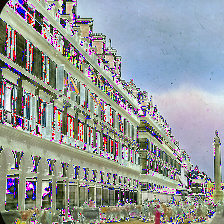

(torch.Size([3, 224, 224]),
 'A vintage picture of people walking around a town')

In [3]:
show_img(train_set[0][0])
train_set[0][0].shape, train_set[0][1]

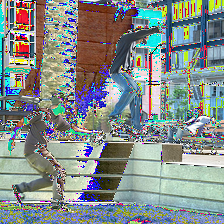

(torch.Size([3, 224, 224]),
 'Man preforming stunt on skateboard outside in the city.')

In [4]:
show_img(val_set[0][0])
val_set[0][0].shape, val_set[0][1]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-L/14", device=device)
text = clip.tokenize("By decomposing the image formation process into a sequential application of denoising autoencoders, \
    diffusion models (DMs) achieve state-of-the-art synthesis results on image data and beyond. Additionally, their formulation al- \
    lows for a guiding mechanism to control the image generation process without retraining.").to(device)
print(text.shape)
with torch.no_grad():
    text_features = model.encode_text(text)
print(text_features.shape)
print(text)

torch.Size([1, 77])
torch.Size([1, 768])
tensor([[49406,   638,   561, 40412,   518,  2867,  2510,  4078,  1095,   320,
          5491,  5194,  7241,   539,  1177,    78,  3426,  3917,   524,   622,
          1923,   267, 18656,  9364,  6176,   263, 19955,   264,  8175,  1295,
           268,   539,   268,   518,   268,   794, 21602,  3790,   525,  2867,
          2281,   537,  4432,   269,   594, 16452,   769,   267,   911, 23923,
           656,   566,   268,  4406,   556,   320, 22759, 22576,   531,  3366,
           518,  2867,  4883,  4078,  2193,   515,  2199,   269, 49407,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)


In [15]:
# what class the model belongs to
print(isinstance(model, nn.Module))

True


In [4]:
# define the dataloader
train_loader = DataLoader(train_set, batch_size=64, shuffle=False, num_workers=0)

In [5]:
for img, text, text_features in tqdm(train_loader):
    pass

  0%|          | 18/9247 [01:40<14:22:43,  5.61s/it]


KeyboardInterrupt: 

In [6]:
val_set[0][2].shape

torch.Size([768])

In [ ]:
all_text = []
with torch.no_grad():
    for _, text in tqdm(train_loader):
        text = clip.tokenize(text).to(device)
        text_features = model.encode_text(text).cpu()
        all_text.append(text_features)
all_text = torch.cat(all_text, dim=0).numpy()
print(all_text.shape)
np.save(osp.join(DATA_ROOT, "annotation_text_features.npy"), all_text)

In [5]:
[None]

[None]